In [1]:
!pip install eli5

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import seaborn as sns
import os.path as path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score
import matplotlib.pyplot as plt
import eli5
import pickle

In [3]:
data_dir = "./ember2018"

In [4]:
fn_X_sample = path.join(data_dir, 'X_sample-100K.dat')
fn_y_sample = path.join(data_dir, 'y_sample-100K.dat')

In [5]:
X = np.memmap(fn_X_sample, dtype='float32', mode='r', shape=(100000, 2381))
y = np.memmap(fn_y_sample, dtype='float32', mode='r', shape=(100000,))

In [6]:
X.shape, y.shape

((100000, 2381), (100000,))

In [7]:
# baseline score
y.mean()

0.5

In [8]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

CPU times: user 260 ms, sys: 556 ms, total: 817 ms
Wall time: 1.37 s


In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000, 2381), (20000, 2381), (80000,), (20000,))

In [10]:
y_train.mean(), y_test.mean()

(0.5, 0.5)

### Standarize the X_train and X_test

In [11]:
ss = StandardScaler()

In [12]:
%%time
ss.fit(X_train)

CPU times: user 2.01 s, sys: 1.34 s, total: 3.35 s
Wall time: 3.43 s


StandardScaler()

In [13]:
%%time
X_train = ss.transform(X_train)

CPU times: user 920 ms, sys: 114 ms, total: 1.03 s
Wall time: 1.04 s


In [14]:
%%time
X_test = ss.transform(X_test)

CPU times: user 239 ms, sys: 39 ms, total: 278 ms
Wall time: 277 ms


In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000, 2381), (20000, 2381), (80000,), (20000,))

# Experiment 1 - RandomForestClassifier

In [16]:
%%time
rfc = RandomForestClassifier(n_jobs=-1, random_state=0, max_depth=40, n_estimators=900, oob_score=True, warm_start=True)

CPU times: user 69 µs, sys: 17 µs, total: 86 µs
Wall time: 90.4 µs


In [17]:
%%time
scores = cross_val_score(rfc, X_train, y_train, cv=5)

CPU times: user 4min 18s, sys: 3min 8s, total: 7min 27s
Wall time: 1h 34min 57s


In [18]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.96 (+/- 0.00)


In [19]:
%%time
rfc.fit(X_train,y_train)

CPU times: user 37min 46s, sys: 46.3 s, total: 38min 33s
Wall time: 20min 28s


RandomForestClassifier(max_depth=40, n_estimators=900, n_jobs=-1,
                       oob_score=True, random_state=0, warm_start=True)

In [20]:
%%time
rfc.score(X_test,y_test) 

CPU times: user 11.3 s, sys: 93.9 ms, total: 11.4 s
Wall time: 5.85 s


0.9661

In [21]:
%%time
y_hat = rfc.predict(X_test)

CPU times: user 11.5 s, sys: 60.4 ms, total: 11.6 s
Wall time: 5.95 s


In [22]:
%%time
y_hat_pr = rfc.predict_proba(X_test)

CPU times: user 11.4 s, sys: 76 ms, total: 11.4 s
Wall time: 5.95 s


In [23]:
print(f'Accuration score with y_test & y_pred: {accuracy_score(y_test,y_hat)}')
print('----------------------------------------')
print('Classification Report')
print('----------------------------------------')
print(classification_report(y_test,y_hat))

Accuration score with y_test & y_pred: 0.9661
----------------------------------------
Classification Report
----------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     10000
         1.0       0.98      0.95      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



In [24]:
print('----------------------------------------')
print('Confusion Matrix')
print('----------------------------------------')
conmat = np.array(confusion_matrix(y_test,y_hat,labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['is_malware', 'is_benign'],
                         columns=['predicted_malware','predicted_benign'])
print(confusion)

----------------------------------------
Confusion Matrix
----------------------------------------
            predicted_malware  predicted_benign
is_malware               9545               455
is_benign                 223              9777


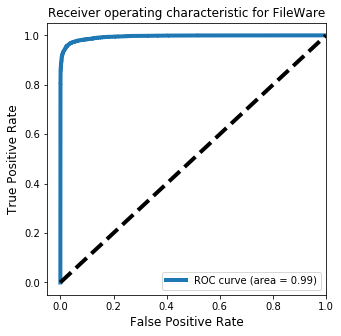

In [25]:
fpr, tpr, th = roc_curve(y_test, y_hat_pr[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[5,5])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver operating characteristic for FileWare', fontsize=12)
plt.legend(loc="lower right")
plt.show()

In [26]:
display(eli5.explain_weights(rfc, top=50))

Weight,Feature
0.0134 ± 0.0553,x2359
0.0124 ± 0.0622,x256
0.0108 ± 0.0422,x2360
0.0090 ± 0.0473,x930
0.0080 ± 0.0369,x691
0.0079 ± 0.0455,x640
0.0074 ± 0.0482,x509
0.0068 ± 0.0494,x500
0.0066 ± 0.0467,x497
0.0066 ± 0.0489,x504


In [29]:
dir(rfc)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_check_n_features',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_make_estimator',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_set_oob_score',
 '_validate_X_predict',
 '_validate_data',
 '_validate_estimator',
 '_validate_y_class_weight',
 'apply',
 'base_estimator',
 'base_estimator_',
 'bootstrap',
 'ccp_alpha',
 'class_weight',
 'classes_',
 'cr

In [30]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 35,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [31]:
# Max depth across estimators (decision tree models)
max([estimator.get_depth() for estimator in rfc.estimators_])

35

In [32]:
max([estimator.get_n_leaves() for estimator in rfc.estimators_])

3321

In [17]:
filename = 'exp-model7.sav'

# Serialize the result of the model

In [27]:
pickle.dump(rfc, open(filename, 'wb'))

# Deserialize the result of the model

In [18]:
#load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [19]:
loaded_model

RandomForestClassifier(max_depth=40, n_estimators=900, n_jobs=-1,
                       oob_score=True, random_state=0, warm_start=True)

In [20]:
#result = loaded_model.score(X_test, y_test)
y_hat1 = loaded_model.predict(X_test)
#print(result)

In [21]:
display(eli5.explain_weights(loaded_model, top=15))

Weight,Feature
0.0134 ± 0.0553,x2359
0.0124 ± 0.0622,x256
0.0108 ± 0.0422,x2360
0.0090 ± 0.0473,x930
0.0080 ± 0.0369,x691
0.0079 ± 0.0455,x640
0.0074 ± 0.0482,x509
0.0068 ± 0.0494,x500
0.0066 ± 0.0467,x497
0.0066 ± 0.0489,x504


In [23]:
df_report = pd.DataFrame(loaded_model.feature_importances_)

In [24]:
df_report

,0
0,0.001397
1,0.003388
2,0.001942
3,0.001327
4,0.001708
...,...
2376,0.001360
2377,0.000266
2378,0.000350
2379,0.001721


In [25]:
df_report.reset_index(inplace=True)

In [26]:
df_report.rename(columns={0: "Feature_Import", "index": "Feature"}, inplace=True)

In [27]:
df_report['Feature_Name'] = "Value"

In [28]:
df_report.sort_values(by=['Feature_Import'], ascending=False, inplace=True)

In [29]:
df_report['Feature_Name'] = df_report['Feature']
df_report

,Feature,Feature_Import,Feature_Name
2359,2359,0.013447,2359
256,256,0.012436,256
2360,2360,0.010791,2360
930,930,0.008972,930
691,691,0.008007,691
...,...,...,...
904,904,0.000000,904
900,900,0.000000,900
899,899,0.000000,899
898,898,0.000000,898


In [30]:
# Function to map features' ID to the feature categories
def feature_modify(x):
    if x in [i for i in range(256)]:
        return "Byte-histogram"
    if x in [i for i in range(256,512)]:
        return "Byte-entropy histogram"
    if x in [i for i in range(512,616)]:
        return "String information"
    if x in [i for i in range(616,626)]:
        return "General file Information"
    if x in [i for i in range(626,688)]:
        return "Header Information"
    if x in [i for i in range(688,943)]:
        return "Section Information"
    if x in [i for i in range(943,2223)]:
        return "Imported Functions"
    if x in [i for i in range(2223,2351)]:
        return "Exported functions"
    if x in [i for i in range(2351,2381)]:
        return "datadirectories"

In [31]:
# Function to map feature categories to features' ID
def feature_modify2(x):
    if x == "Byte-histogram":
        return "0-255"
    if x == "Byte-entropy histogram":
        return "256-511"
    if x == "String information":
        return "512-615"
    if x == "General file Information":
        return "616-626"
    if x == "Header Information":
        return "627-688"
    if x == "Section Information":
        return "689-942"
    if x == "Imported Functions":
        return "943-2222"
    if x == "Exported functions":
        return "2223-2350"
    if x == "datadirectories":
        return "2351-2380"

In [32]:
df_report['Feature_Name'] = df_report['Feature_Name'].apply(feature_modify)

In [33]:
df_report

,Feature,Feature_Import,Feature_Name
2359,2359,0.013447,datadirectories
256,256,0.012436,Byte-entropy histogram
2360,2360,0.010791,datadirectories
930,930,0.008972,Section Information
691,691,0.008007,Section Information
...,...,...,...
904,904,0.000000,Section Information
900,900,0.000000,Section Information
899,899,0.000000,Section Information
898,898,0.000000,Section Information


In [34]:
df_fea_rep = df_report.groupby(['Feature_Name']).sum().reset_index()

In [35]:
df_fea_rep["Feature"] = df_fea_rep["Feature_Name"]
df_fea_rep

,Feature_Name,Feature,Feature_Import
0,Byte-entropy histogram,Byte-entropy histogram,0.256012
1,Byte-histogram,Byte-histogram,0.298666
2,Exported functions,Exported functions,0.002854
3,General file Information,General file Information,0.016141
4,Header Information,Header Information,0.038710
5,Imported Functions,Imported Functions,0.092838
6,Section Information,Section Information,0.078472
7,String information,String information,0.160681
8,datadirectories,datadirectories,0.055625


In [36]:
df_fea_rep['Feature'] = df_fea_rep['Feature'].apply(feature_modify2)

In [37]:
df_fea_rep.sort_values(by=['Feature_Import'], ascending=False, inplace=True)

In [38]:
df_fea_rep.rename(columns={"Feature_Import": "Feature Importance Weight"}, inplace=True)

Text(0.5, 1.0, 'Feature Importance Aggregation')

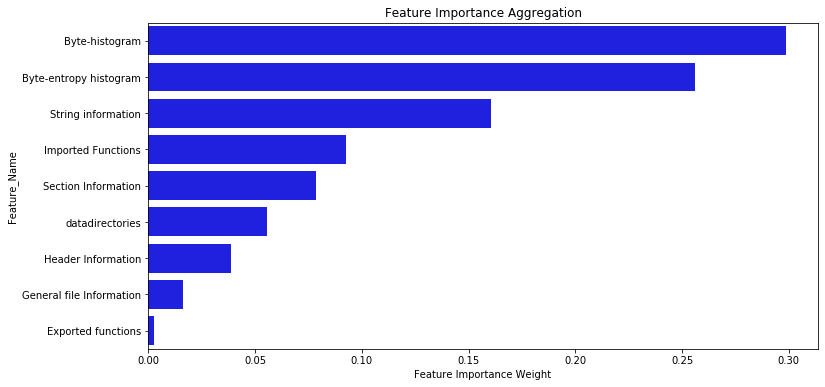

In [39]:
f, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="Feature Importance Weight",y="Feature_Name", data=df_fea_rep, color="b")
plt.title('Feature Importance Aggregation')

In [41]:
y_hat_pr = loaded_model.predict_proba(X_test)

In [42]:
fpr, tpr, th = roc_curve(y_test, y_hat_pr[:,1])
roc_auc = auc(fpr, tpr)

In [43]:
fpr, tpr, th

(array([0.    , 0.    , 0.    , ..., 0.9931, 0.9933, 1.    ]),
 array([0.    , 0.0016, 0.0018, ..., 1.    , 1.    , 1.    ]),
 array([2.00000000e+00, 1.00000000e+00, 9.99995411e-01, ...,
        6.41519117e-07, 2.71399881e-07, 0.00000000e+00]))

In [44]:
df = pd.DataFrame(fpr)

In [45]:
df[1] = tpr

In [46]:
df[2] = th

In [47]:
df

,0,1,2
0,0.0000,0.0000,2.000000e+00
1,0.0000,0.0016,1.000000e+00
2,0.0000,0.0018,9.999954e-01
3,0.0000,0.0021,9.999953e-01
4,0.0000,0.0025,9.999916e-01
...,...,...,...
2292,0.9922,1.0000,1.039393e-06
2293,0.9923,1.0000,8.392078e-07
2294,0.9931,1.0000,6.415191e-07
2295,0.9933,1.0000,2.713999e-07


# Adjusting threshold to have zero false positive and false negative

In [48]:
y_hat_prt1 = np.where( loaded_model.predict_proba(X_test)[:,1]>0.01, 1, 0 )

In [49]:
print('----------------------------------------')
print('Confusion Matrix')
print('----------------------------------------')
conmat = np.array(confusion_matrix(y_test,y_hat_prt1,labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['is_malware', 'is_benign'],
                         columns=['predicted_malware','predicted_benign'])
print(confusion)

----------------------------------------
Confusion Matrix
----------------------------------------
            predicted_malware  predicted_benign
is_malware              10000                 0
is_benign                7288              2712


In [51]:
y_hat_prt2 = np.where( loaded_model.predict_proba(X_test)[:,1]>0.91, 1, 0 )

In [52]:
print('----------------------------------------')
print('Confusion Matrix')
print('----------------------------------------')
conmat = np.array(confusion_matrix(y_test,y_hat_prt2,labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['is_malware', 'is_benign'],
                         columns=['predicted_malware','predicted_benign'])
print(confusion)

----------------------------------------
Confusion Matrix
----------------------------------------
            predicted_malware  predicted_benign
is_malware               7417              2583
is_benign                   0             10000
